# LIAR DATASET

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 17.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import transformers
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Conv2D,MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, BatchNormalization, Input, Concatenate, GlobalMaxPooling1D
import requests
from tensorflow.keras import activations, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical

## Train data

In [ ]:
path = '/content/drive/MyDrive/LIAR_DATASET/Train.csv'
df_train = pd.read_csv(path,delimiter=',')

In [ ]:
df_train.head()

,Label,Statement
0,false,Says the Annies List political group supports ...
1,half-true,When did the decline of coal start? It started...
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo..."
3,false,Health care reform legislation is likely to ma...
4,half-true,The economic turnaround started at the end of ...


In [ ]:
label_encoder = LabelEncoder()
label = df_train['Label']
labels_encoded = label_encoder.fit_transform(label)
df_train['category'] = labels_encoded
df_train['category'].unique()

array([1, 2, 3, 5, 0, 4])

In [ ]:
df_train.head()

,Label,Statement,category
0,false,Says the Annies List political group supports ...,1
1,half-true,When did the decline of coal start? It started...,2
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",3
3,false,Health care reform legislation is likely to ma...,1
4,half-true,The economic turnaround started at the end of ...,2


In [ ]:
df_train.isnull().sum()

Label        0
Statement    0
category     0
dtype: int64

## Test data

In [ ]:
path = '/content/drive/MyDrive/LIAR_DATASET/Test.csv'
df_test = pd.read_csv(path,delimiter=',')

In [ ]:
df_test.head()

,Label,Statement
0,true,Building a wall on the U.S.-Mexico border will...
1,false,Wisconsin is on pace to double the number of l...
2,false,Says John McCain has done nothing to help the ...
3,half-true,Suzanne Bonamici supports a plan that will cut...
4,pants-fire,When asked by a reporter whether hes at the ce...


In [ ]:
label_encoder = LabelEncoder()
label = df_test['Label']
labels_encoded = label_encoder.fit_transform(label)
df_test['category'] = labels_encoded
df_test['category'].unique()

array([5, 1, 2, 4, 0, 3])

In [ ]:
df_test.isnull().sum()

Label        0
Statement    0
category     0
dtype: int64

## Valid data

In [ ]:
path = '/content/drive/MyDrive/LIAR_DATASET/Valid.csv'
df_valid = pd.read_csv(path,delimiter=',')

In [ ]:
df_valid.head()

,Label,Statement
0,barely-true,We have less Americans working now than in the...
1,pants-fire,"When Obama was sworn into office, he DID NOT u..."
2,false,Says Having organizations parading as being so...
3,half-true,Says nearly half of Oregons children are poor.
4,half-true,On attacks by Republicans that various program...


In [ ]:
label_encoder = LabelEncoder()
label = df_valid['Label']
labels_encoded = label_encoder.fit_transform(label)
df_valid['category'] = labels_encoded
df_valid['category'].unique()

array([0, 4, 1, 2, 5, 3])

In [ ]:
df_valid.isnull().sum()

Label        0
Statement    0
category     0
dtype: int64

# DistilBERT Embeddings

In [ ]:
tokenizer_distil = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',padding=True, truncation=True, return_tensors='tf',add_special_tokens=True)
model_distil = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=6,output_hidden_states=True)

for layer in model_distil.layers:
    layer.trainable = True

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
def get_embeddings(texts):
    encoded = tokenizer_distil(
      texts,
      add_special_tokens=True,
      padding=True,
      truncation=True,
      max_length=512,
      return_tensors="tf"
    )
    outputs = model_distil(encoded)
    embeddings = outputs.hidden_states[-1]
    avg_embeddings = tf.reduce_mean(embeddings, axis=1)
    return avg_embeddings

## train

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df_train['Statement'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]
  
    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

100%|██████████| 10269/10269 [18:45<00:00,  9.12it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df_train['category'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/LIAR_DATASET/embeddings_train_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/LIAR_DATASET/labels_train_distilbert.npy', labels)

## test

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df_test['Statement'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]
  
    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

100%|██████████| 1283/1283 [02:21<00:00,  9.06it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df_test['category'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/LIAR_DATASET/embeddings_test_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/LIAR_DATASET/labels_test_distilbert.npy', labels)

## valid

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df_valid['Statement'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]
  
    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

100%|██████████| 1284/1284 [02:23<00:00,  8.96it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df_valid['category'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/LIAR_DATASET/embeddings_valid_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/LIAR_DATASET/labels_valid_distilbert.npy', labels)

# DistilBERT Train

In [ ]:
num_nan = df_train['Label'].isnull().sum()
print(num_nan)

0


In [ ]:
df_train['Statement'] = df_train['Statement'].astype(str)
df_test['Statement'] = df_test['Statement'].astype(str)
df_valid['Statement'] = df_valid['Statement'].astype(str)

In [ ]:
train_encodings = tokenizer_distil(df_train['Statement'].tolist(), truncation = True, padding = True  )

val_encodings = tokenizer_distil(df_valid['Statement'].tolist(), truncation = True, padding = True )

test_encodings = tokenizer_distil(df_test['Statement'].tolist(), truncation = True, padding = True  )


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    df_train['category'].tolist()
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    df_valid['category'].tolist()
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    df_test['category'].tolist()
))

In [ ]:
train_dataset = train_dataset.batch(2)
val_dataset = val_dataset.batch(2)
test_dataset = test_dataset.batch(2)

In [ ]:
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model_distil.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model_distil.fit(train_dataset, batch_size=2, epochs=2,validation_data=val_dataset)

Epoch 1/2
5135/5135 [==============================] - 297s 52ms/step - loss: 1.7245 - accuracy: 0.2399 - val_loss: 1.6936 - val_accuracy: 0.2430
Epoch 2/2
5135/5135 [==============================] - 245s 48ms/step - loss: 1.6074 - accuracy: 0.3078 - val_loss: 1.7669 - val_accuracy: 0.2414


In [ ]:
benchmarks = model_distil.evaluate(test_dataset, return_dict=True, batch_size=2)

642/642 [==============================] - 15s 21ms/step - loss: 1.7193 - accuracy: 0.2783


# **Paper CNN-DistilBERT**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
train_embeddings = np.load('/content/drive/MyDrive/LIAR_DATASET/embeddings_train_distilbert.npy')
train_labels = np.load('/content/drive/MyDrive/LIAR_DATASET/labels_train_distilbert.npy')

In [ ]:
test_embeddings = np.load('/content/drive/MyDrive/LIAR_DATASET/embeddings_test_distilbert.npy')
test_labels = np.load('/content/drive/MyDrive/LIAR_DATASET/labels_test_distilbert.npy')

In [ ]:
valid_embeddings = np.load('/content/drive/MyDrive/LIAR_DATASET/embeddings_valid_distilbert.npy')
valid_labels = np.load('/content/drive/MyDrive/LIAR_DATASET/labels_valid_distilbert.npy')

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)
valid_embeddings = tf.expand_dims(valid_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([10269, 768, 1])

In [ ]:
test_embeddings.shape

TensorShape([1283, 768, 1])

In [ ]:
valid_embeddings.shape

TensorShape([1284, 768, 1])

In [ ]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels, num_classes=6)
valid_labels = to_categorical(valid_labels, num_classes=6)

In [ ]:
train_labels.shape

(10269, 6)

In [ ]:
# build the model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels, epochs=10, batch_size=16,validation_data=(valid_embeddings, valid_labels))

Epoch 1/10
642/642 [==============================] - 11s 15ms/step - loss: 0.3788 - accuracy: 0.4220 - val_loss: 0.4494 - val_accuracy: 0.2632
Epoch 2/10
642/642 [==============================] - 7s 10ms/step - loss: 0.3736 - accuracy: 0.4374 - val_loss: 0.4527 - val_accuracy: 0.2679
Epoch 3/10
642/642 [==============================] - 9s 14ms/step - loss: 0.3723 - accuracy: 0.4330 - val_loss: 0.4524 - val_accuracy: 0.2664
Epoch 4/10
642/642 [==============================] - 5s 9ms/step - loss: 0.3713 - accuracy: 0.4362 - val_loss: 0.4531 - val_accuracy: 0.2695
Epoch 5/10
642/642 [==============================] - 9s 14ms/step - loss: 0.3689 - accuracy: 0.4425 - val_loss: 0.4582 - val_accuracy: 0.2648
Epoch 6/10
642/642 [==============================] - 5s 9ms/step - loss: 0.3678 - accuracy: 0.4447 - val_loss: 0.4613 - val_accuracy: 0.2679
Epoch 7/10
642/642 [==============================] - 9s 14ms/step - loss: 0.3674 - accuracy: 0.4494 - val_loss: 0.4588 - val_accuracy: 0.2632


In [ ]:
test_labels = to_categorical(test_labels, num_classes=6)

In [ ]:
test_labels.shape

(1283, 6)

In [ ]:
a = np.asarray(test_labels).argmax(axis=1)

In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)



f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

41/41 [==============================] - 0s 2ms/step
Test Accuracy: 0.2704598605632782
Test F1 Score: 0.26377974894233813
Test Recall: 0.2593853276470031
Precision: 0.29076908220290576


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 764, 128)          768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 152, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 148, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 29, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 128)           82048     
                                                                 
 flatten (Flatten)           (None, 3200)              0

In [ ]:
model.save('cnn_distilbert_.h5')

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)

41/41 [==============================] - 0s 2ms/step
[[34 68 62 25  9 16]
 [29 89 62 27 12 31]
 [21 70 96 45  5 30]
 [10 48 91 57  2 41]
 [11 34 15  8 19  5]
 [ 6 43 48 58  4 52]]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):
   # Plot training and validation loss
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()
    
    # Plot training and validation accuracy
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()
    
    # Print the classification report
    print(classification_report(a, y_pred))

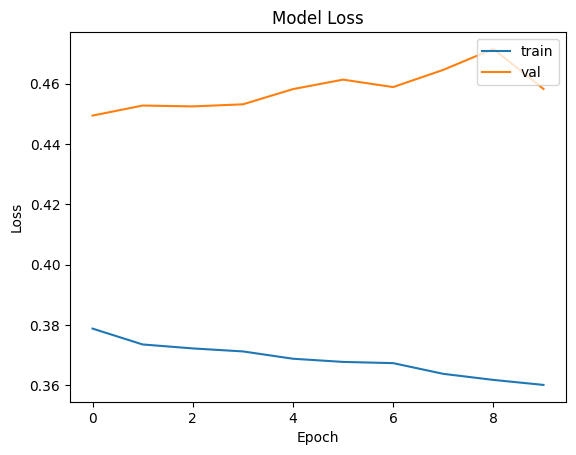

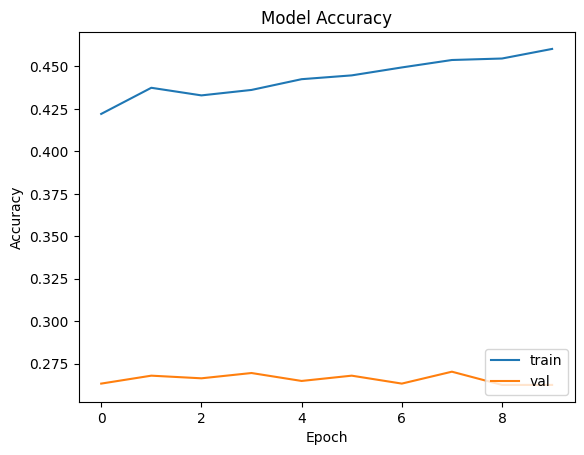

              precision    recall  f1-score   support

           0       0.31      0.16      0.21       214
           1       0.25      0.36      0.30       250
           2       0.26      0.36      0.30       267
           3       0.26      0.23      0.24       249
           4       0.37      0.21      0.27        92
           5       0.30      0.25      0.27       211

    accuracy                           0.27      1283
   macro avg       0.29      0.26      0.26      1283
weighted avg       0.28      0.27      0.27      1283



In [ ]:
plot_history(history1,model)

# **Simple CNN - DistilBERT**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
model2.add(GlobalMaxPooling1D())
model2.add(Flatten())
model2.add(Dense(units=64, activation='relu'))
model2.add(Dense(units=6, activation='softmax'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=10, batch_size=16,validation_data=(valid_embeddings, valid_labels))

Epoch 1/10
642/642 [==============================] - 5s 8ms/step - loss: 0.4219 - accuracy: 0.3071 - val_loss: 0.4454 - val_accuracy: 0.2259
Epoch 2/10
642/642 [==============================] - 4s 7ms/step - loss: 0.4136 - accuracy: 0.3285 - val_loss: 0.4454 - val_accuracy: 0.2391
Epoch 3/10
642/642 [==============================] - 4s 7ms/step - loss: 0.4062 - accuracy: 0.3462 - val_loss: 0.4458 - val_accuracy: 0.2414
Epoch 4/10
642/642 [==============================] - 3s 4ms/step - loss: 0.4018 - accuracy: 0.3624 - val_loss: 0.4454 - val_accuracy: 0.2305
Epoch 5/10
642/642 [==============================] - 4s 6ms/step - loss: 0.3984 - accuracy: 0.3646 - val_loss: 0.4526 - val_accuracy: 0.2368
Epoch 6/10
642/642 [==============================] - 3s 4ms/step - loss: 0.3970 - accuracy: 0.3722 - val_loss: 0.4486 - val_accuracy: 0.2321
Epoch 7/10
642/642 [==============================] - 3s 4ms/step - loss: 0.3958 - accuracy: 0.3738 - val_loss: 0.4467 - val_accuracy: 0.2407
Epoch 

In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels)

y_pred = model2.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)



f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

41/41 [==============================] - 0s 2ms/step
Test Accuracy: 0.272018700838089
Test F1 Score: 0.2447070676012194
Test Recall: 0.24818664536614585
Precision: 0.29439957059290434


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 766, 32)           128       
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 2,630
Trainable params: 2,630
Non-trainable params: 0
____________________________________________________

In [ ]:
y_pred = model2.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)

41/41 [==============================] - 0s 2ms/step
[[ 31  57  95  13   7  11]
 [ 22  88  99  20   8  13]
 [ 24  58 136  24   4  21]
 [ 16  42 111  50   2  28]
 [ 14  36  24   2  12   4]
 [  6  46  87  38   2  32]]


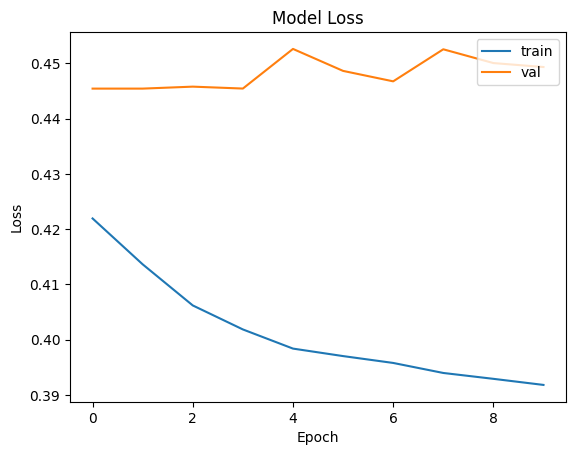

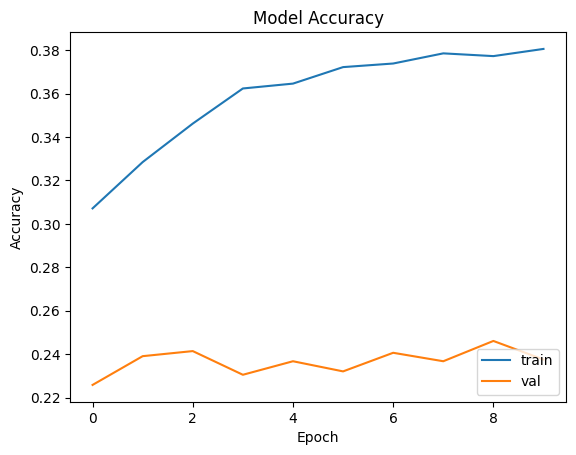

              precision    recall  f1-score   support

           0       0.27      0.14      0.19       214
           1       0.27      0.35      0.31       250
           2       0.25      0.51      0.33       267
           3       0.34      0.20      0.25       249
           4       0.34      0.13      0.19        92
           5       0.29      0.15      0.20       211

    accuracy                           0.27      1283
   macro avg       0.29      0.25      0.24      1283
weighted avg       0.29      0.27      0.26      1283



In [ ]:
plot_history(history2,model2)

# **LIAR DATASET BINARY**

In [ ]:
def map_label(label):
    if label == 'true':
        return 1
    else:
        return 0

## Train data

In [ ]:
path = '/content/drive/MyDrive/LIAR_DATASET/Train.csv'
df_train = pd.read_csv(path,delimiter=',')

In [ ]:
df_train.head()

In [ ]:
df_train['category'] = df_train['Label'].apply(map_label)
df_train['category'].unique()

In [ ]:
df_train.head()

,Label,Statement,category
0,barely-true,700 jobs (were) lost because Allen Boyd voted ...,0
1,mostly-true,"Today, the five largest financial institutions...",0
2,mostly-true,The top one-tenth of 1 percent of Americans ow...,0
3,half-true,Says federal law enforcement officers cut off ...,0
4,pants-fire,Back door gun control is in full effect in the...,0


In [ ]:
df_train.isnull().sum()

Label        0
Statement    0
category     0
dtype: int64

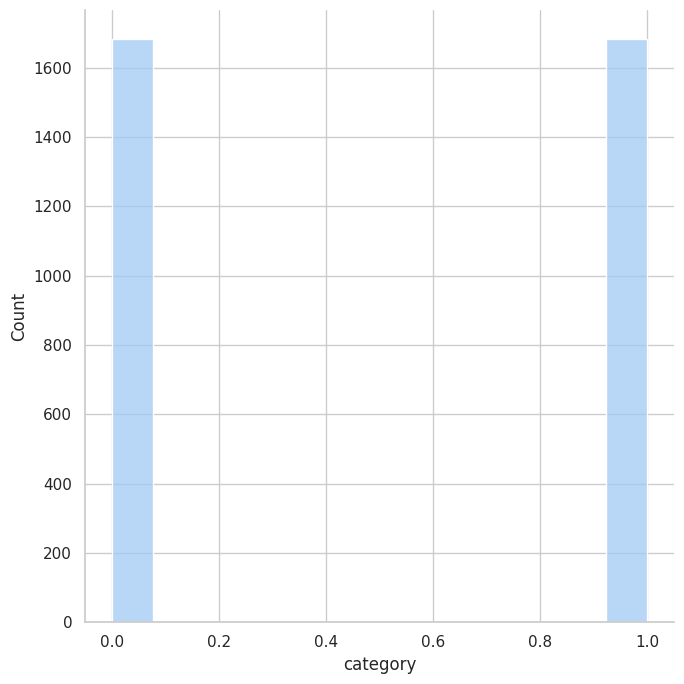

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")
sns.displot(df_train, x="category",height=7,aspect=1)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

ros = RandomUnderSampler(random_state=42)
df_train, df_train['category'] = ros.fit_resample(df_train, df_train['category'])

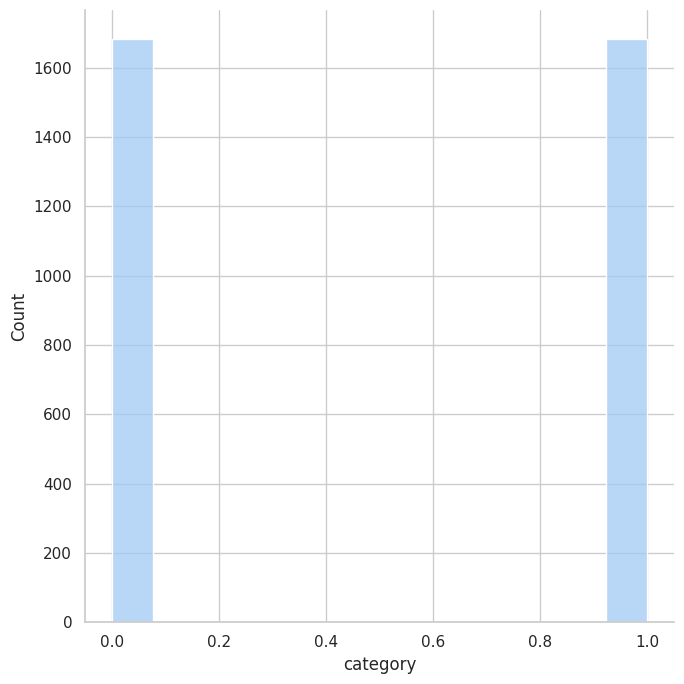

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")
sns.displot(df_train, x="category",height=7,aspect=1)

## Test data

In [ ]:
path = '/content/drive/MyDrive/LIAR_DATASET/Test.csv'
df_test = pd.read_csv(path,delimiter=',')

In [ ]:
df_test.head()

,Label,Statement
0,true,Building a wall on the U.S.-Mexico border will...
1,false,Wisconsin is on pace to double the number of l...
2,false,Says John McCain has done nothing to help the ...
3,half-true,Suzanne Bonamici supports a plan that will cut...
4,pants-fire,When asked by a reporter whether hes at the ce...


In [ ]:
df_test['category'] = df_test['Label'].apply(map_label)
df_test['category'].unique()

array([1, 0])

In [ ]:
df_test.isnull().sum()

Label        0
Statement    0
category     0
dtype: int64

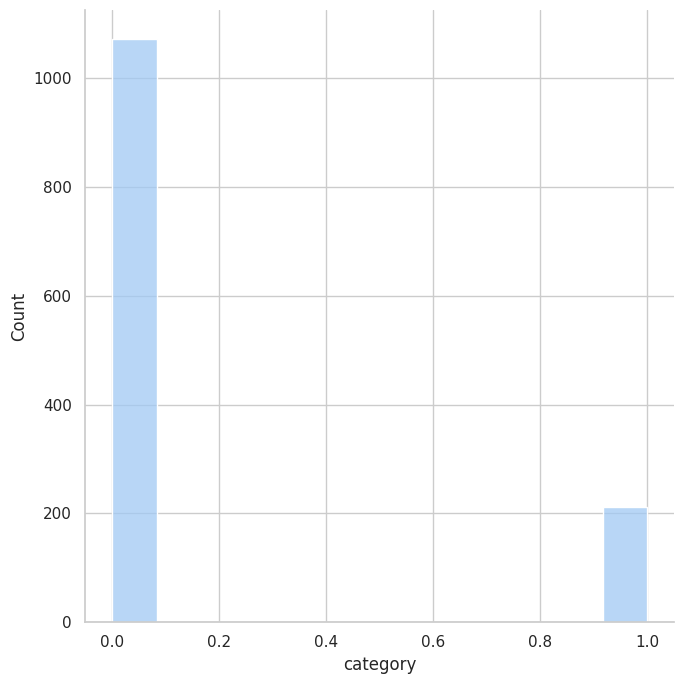

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")
sns.displot(df_test, x="category",height=7,aspect=1)

In [ ]:
ros = RandomUnderSampler(random_state=42)
df_test, df_test['category'] = ros.fit_resample(df_test, df_test['category'])

## Valid data

In [ ]:
path = '/content/drive/MyDrive/LIAR_DATASET/Valid.csv'
df_valid = pd.read_csv(path,delimiter=',')

In [ ]:
df_valid.head()

,Label,Statement
0,barely-true,We have less Americans working now than in the...
1,pants-fire,"When Obama was sworn into office, he DID NOT u..."
2,false,Says Having organizations parading as being so...
3,half-true,Says nearly half of Oregons children are poor.
4,half-true,On attacks by Republicans that various program...


In [ ]:
df_valid['category'] = df_valid['Label'].apply(map_label)
df_valid['category'].unique()

array([0, 1])

In [ ]:
df_valid.isnull().sum()

Label        0
Statement    0
category     0
dtype: int64

In [ ]:
ros = RandomUnderSampler(random_state=42)
df_valid, df_valid['category'] = ros.fit_resample(df_valid, df_valid['category'])

## DistilBERT train

In [ ]:
tokenizer_distil = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',padding=True, truncation=True, return_tensors='tf',add_special_tokens=True)
model_distil = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=2,output_hidden_states=True)

#model_distil.trainable = False
for layer in model_distil.layers[:-2]:
    layer.trainable = False

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_103', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

In [ ]:
def get_embeddings(texts):
    encoded = tokenizer_distil(
      texts,
      add_special_tokens=True,
      padding=True,
      truncation=True,
      max_length=512,
      return_tensors="tf"
    )
    outputs = model_distil(encoded)
    embeddings = outputs.hidden_states[-1]
    avg_embeddings = tf.reduce_mean(embeddings, axis=1)
    return avg_embeddings

In [ ]:
df_train['Statement'] = df_train['Statement'].astype(str)
df_test['Statement'] = df_test['Statement'].astype(str)
df_valid['Statement'] = df_valid['Statement'].astype(str)

In [ ]:
train_encodings = tokenizer_distil(df_train['Statement'].tolist(), truncation = True, padding = True  )

val_encodings = tokenizer_distil(df_valid['Statement'].tolist(), truncation = True, padding = True )

test_encodings = tokenizer_distil(df_test['Statement'].tolist(), truncation = True, padding = True  )


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    df_train['category'].tolist()
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    df_valid['category'].tolist()
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    df_test['category'].tolist()
))

In [ ]:
train_dataset = train_dataset.batch(2)
val_dataset = val_dataset.batch(2)
test_dataset = test_dataset.batch(2)

In [ ]:
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model_distil.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model_distil.fit(train_dataset, batch_size=2, epochs=2,validation_data=val_dataset)

Epoch 1/2
1683/1683 [==============================] - 65s 34ms/step - loss: 0.5466 - accuracy: 0.7796 - val_loss: 1.3130 - val_accuracy: 0.1316
Epoch 2/2
1683/1683 [==============================] - 52s 31ms/step - loss: 0.6251 - accuracy: 0.6640 - val_loss: 1.3902 - val_accuracy: 0.1316


In [ ]:
benchmarks = model_distil.evaluate(test_dataset, return_dict=True, batch_size=2)

642/642 [==============================] - 18s 25ms/step - loss: 1.3481 - accuracy: 0.1645


## train

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df_train['Statement'].tolist()
embeddings = []

for i in range(0, len(titles), batch_size):
    batch_titles = titles[i:i+batch_size]
  
    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df_train['category'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/LIAR_DATASET/embeddings_train_distilbert_bin.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/LIAR_DATASET/labels_train_distilbert_bin.npy', labels)

## test

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df_test['Statement'].tolist()
embeddings = []

for i in range(0, len(titles), batch_size):
    batch_titles = titles[i:i+batch_size]
  
    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df_test['category'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/LIAR_DATASET/embeddings_test_distilbert_bin.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/LIAR_DATASET/labels_test_distilbert_bin.npy', labels)

## valid

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df_valid['Statement'].tolist()
embeddings = []

for i in range(0, len(titles), batch_size):
    batch_titles = titles[i:i+batch_size]
  
    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df_valid['category'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/LIAR_DATASET/embeddings_valid_distilbert_bin.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/LIAR_DATASET/labels_valid_distilbert_bin.npy', labels)

# **CNN - Binary**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
train_embeddings = np.load('/content/drive/MyDrive/LIAR_DATASET/embeddings_train_distilbert_bin.npy')
train_labels = np.load('/content/drive/MyDrive/LIAR_DATASET/labels_train_distilbert_bin.npy')

In [ ]:
test_embeddings = np.load('/content/drive/MyDrive/LIAR_DATASET/embeddings_test_distilbert_bin.npy')
test_labels = np.load('/content/drive/MyDrive/LIAR_DATASET/labels_test_distilbert_bin.npy')

In [ ]:
valid_embeddings = np.load('/content/drive/MyDrive/LIAR_DATASET/embeddings_valid_distilbert_bin.npy')
valid_labels = np.load('/content/drive/MyDrive/LIAR_DATASET/labels_valid_distilbert_bin.npy')

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)
valid_embeddings = tf.expand_dims(valid_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([3366, 768, 1])

In [ ]:
test_embeddings.shape

TensorShape([1283, 768, 1])

In [ ]:
valid_embeddings.shape

TensorShape([1284, 768, 1])

In [ ]:
# build the model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(768,1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(32, 5, activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels, epochs=10, batch_size=4,validation_data=(valid_embeddings, valid_labels))

Epoch 1/10
842/842 [==============================] - 9s 11ms/step - loss: 0.6613 - accuracy: 0.6010 - val_loss: 0.7292 - val_accuracy: 0.4821
Epoch 2/10
842/842 [==============================] - 8s 10ms/step - loss: 0.6457 - accuracy: 0.6257 - val_loss: 0.6933 - val_accuracy: 0.5849
Epoch 3/10
842/842 [==============================] - 7s 8ms/step - loss: 0.6336 - accuracy: 0.6527 - val_loss: 0.7313 - val_accuracy: 0.5545
Epoch 4/10
842/842 [==============================] - 6s 7ms/step - loss: 0.6222 - accuracy: 0.6533 - val_loss: 0.6715 - val_accuracy: 0.6215
Epoch 5/10
842/842 [==============================] - 4s 5ms/step - loss: 0.6100 - accuracy: 0.6702 - val_loss: 0.6818 - val_accuracy: 0.6417
Epoch 6/10
842/842 [==============================] - 5s 7ms/step - loss: 0.5993 - accuracy: 0.6744 - val_loss: 0.7774 - val_accuracy: 0.5537
Epoch 7/10
842/842 [==============================] - 5s 6ms/step - loss: 0.5843 - accuracy: 0.6928 - val_loss: 0.6946 - val_accuracy: 0.5810
Epoc

In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

41/41 [==============================] - 0s 2ms/step
Test Accuracy: 0.6547155380249023
Test F1 Score: 0.30236220472440944
Test Recall: 0.4549763033175355
Precision: 0.22641509433962265


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_41 (Conv1D)          (None, 764, 32)           192       
                                                                 
 max_pooling1d_30 (MaxPoolin  (None, 152, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_42 (Conv1D)          (None, 148, 32)           5152      
                                                                 
 max_pooling1d_31 (MaxPoolin  (None, 29, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_43 (Conv1D)          (None, 25, 32)            5152      
                                                                 
 flatten_13 (Flatten)        (None, 800)             

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)

41/41 [==============================] - 0s 2ms/step
[[744 328]
 [115  96]]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):
   # Plot training and validation loss
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()
    
    # Plot training and validation accuracy
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

    y_pred = model.predict(test_embeddings)
    y_pred = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(test_labels, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion matrix')
    plt.show()
    
    # Print the classification report
    print(classification_report(test_labels, y_pred))

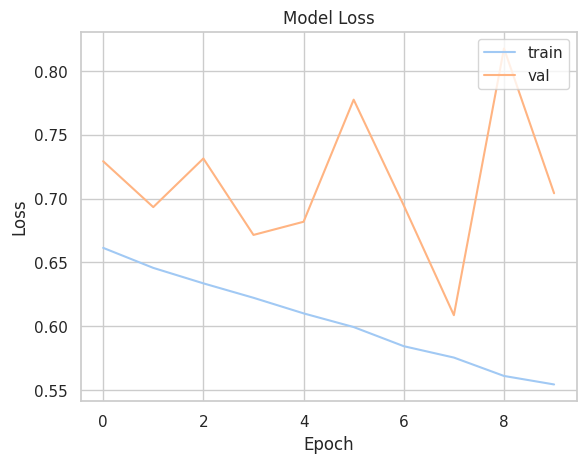

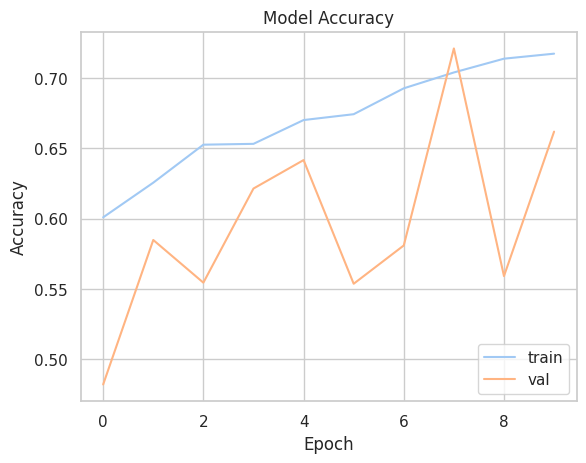

41/41 [==============================] - 0s 2ms/step


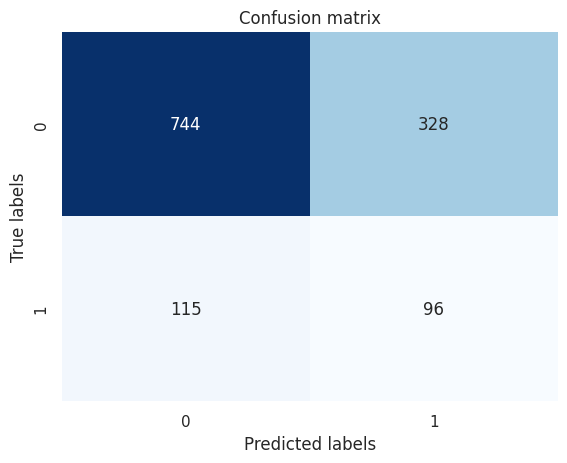

              precision    recall  f1-score   support

           0       0.87      0.69      0.77      1072
           1       0.23      0.45      0.30       211

    accuracy                           0.65      1283
   macro avg       0.55      0.57      0.54      1283
weighted avg       0.76      0.65      0.69      1283



In [ ]:
plot_history(history1,model)

# **LSTM - Binary**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(64, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
211/211 [==============================] - 7s 16ms/step - loss: 1.0439 - accuracy: 0.5140 - val_loss: 0.8269 - val_accuracy: 0.8161
Epoch 2/10
211/211 [==============================] - 4s 17ms/step - loss: 0.7600 - accuracy: 0.5395 - val_loss: 0.6959 - val_accuracy: 0.8309
Epoch 3/10
211/211 [==============================] - 3s 14ms/step - loss: 0.6983 - accuracy: 0.5597 - val_loss: 0.6066 - val_accuracy: 0.7973
Epoch 4/10
211/211 [==============================] - 3s 12ms/step - loss: 0.6822 - accuracy: 0.5683 - val_loss: 0.6658 - val_accuracy: 0.6383
Epoch 5/10
211/211 [==============================] - 3s 12ms/step - loss: 0.6785 - accuracy: 0.5856 - val_loss: 0.8815 - val_accuracy: 0.2876
Epoch 6/10
211/211 [==============================] - 2s 12ms/step - loss: 0.6740 - accuracy: 0.5841 - val_loss: 0.6626 - val_accuracy: 0.6274
Epoch 7/10
211/211 [==============================] - 3s 16ms/step - loss: 0.6639 - accuracy: 0.6102 - val_loss: 0.6004 - val_accuracy: 0.7093

In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model2.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

41/41 - 0s - loss: 0.8672 - accuracy: 0.4435 - 332ms/epoch - 8ms/step
41/41 [==============================] - 1s 6ms/step
Test Accuracy: 0.4434918165206909
Test F1 Score: 0.3276836158192091
Test Recall: 0.8246445497630331
Precision: 0.2044653349001175


In [ ]:
model2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_44 (Conv1D)          (None, 764, 64)           384       
                                                                 
 max_pooling1d_32 (MaxPoolin  (None, 382, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_45 (Conv1D)          (None, 378, 64)           20544     
                                                                 
 max_pooling1d_33 (MaxPoolin  (None, 189, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_46 (Conv1D)          (None, 185, 64)           20544     
                                                                 
 lstm_2 (LSTM)               (None, 185, 64)         

In [ ]:
model2.save('lstm_base.h5')

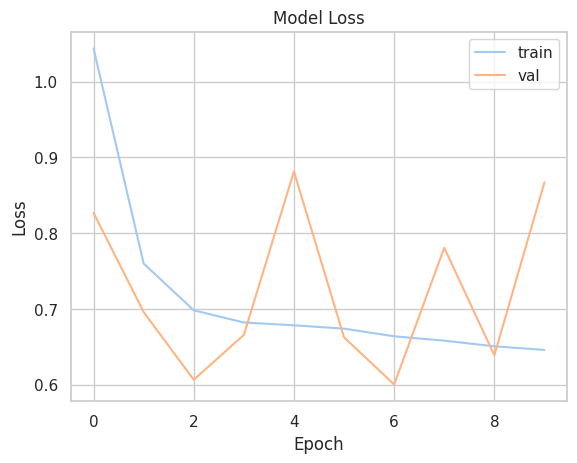

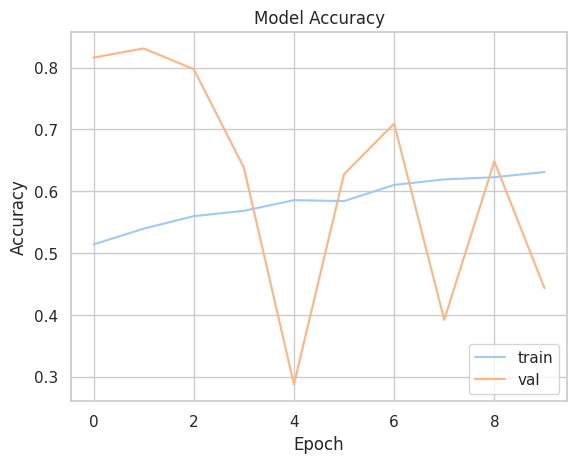

41/41 [==============================] - 0s 5ms/step


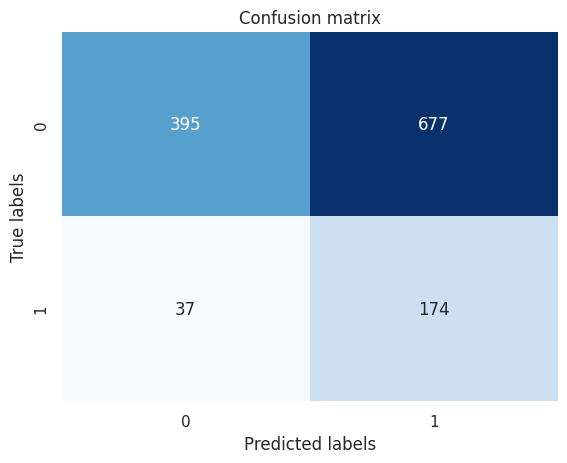

              precision    recall  f1-score   support

           0       0.91      0.37      0.53      1072
           1       0.20      0.82      0.33       211

    accuracy                           0.44      1283
   macro avg       0.56      0.60      0.43      1283
weighted avg       0.80      0.44      0.49      1283



In [ ]:
plot_history(history2,model2)

# **FakeBert - Binary**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(32, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(32, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(32, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=2)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(32, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(32, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(16, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(1, activation='sigmoid')(dropout2)

model3 = Model(inputs=inputs, outputs=output)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
211/211 [==============================] - 7s 8ms/step - loss: 0.6951 - accuracy: 0.4890 - val_loss: 0.6828 - val_accuracy: 0.8355
Epoch 2/10
211/211 [==============================] - 1s 6ms/step - loss: 0.6937 - accuracy: 0.4938 - val_loss: 0.6913 - val_accuracy: 0.8215
Epoch 3/10
211/211 [==============================] - 1s 7ms/step - loss: 0.6934 - accuracy: 0.4804 - val_loss: 0.6947 - val_accuracy: 0.2237
Epoch 4/10
211/211 [==============================] - 1s 6ms/step - loss: 0.6930 - accuracy: 0.5152 - val_loss: 0.7081 - val_accuracy: 0.3811
Epoch 5/10
211/211 [==============================] - 1s 6ms/step - loss: 0.6914 - accuracy: 0.5205 - val_loss: 0.6961 - val_accuracy: 0.4770
Epoch 6/10
211/211 [==============================] - 1s 7ms/step - loss: 0.6898 - accuracy: 0.5401 - val_loss: 0.6798 - val_accuracy: 0.7116
Epoch 7/10
211/211 [==============================] - 2s 7ms/step - loss: 0.6851 - accuracy: 0.5564 - val_loss: 0.6803 - val_accuracy: 0.6820
Epoch 

In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

41/41 - 0s - loss: 0.6564 - accuracy: 0.7147 - 206ms/epoch - 5ms/step
41/41 [==============================] - 0s 2ms/step
Test Accuracy: 0.7147310972213745
Test F1 Score: 0.3272058823529412
Test Recall: 0.4218009478672986
Precision: 0.2672672672672673


In [ ]:
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d_51 (Conv1D)             (None, 768, 32)      128         ['input_4[0][0]']                
                                                                                                  
 conv1d_52 (Conv1D)             (None, 768, 32)      160         ['input_4[0][0]']                
                                                                                                  
 conv1d_53 (Conv1D)             (None, 768, 32)      192         ['input_4[0][0]']                
                                                                                            

In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)

41/41 [==============================] - 0s 2ms/step
[[828 244]
 [122  89]]
